# Machine Learning on ATLAS Open Data

In [1]:
import sys
import pickle
import json
import numpy as np
from numpy import random
import pandas as pd
import os.path
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import uproot
import vector
import awkward

In [3]:
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import math
# SKL
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
import time

In [5]:
from Utilities import *

In [6]:
import glob

In [7]:
from keras.models import Sequential, load_model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [8]:
from tensorflow.python.client import device_lib 

In [9]:
import xgboost as XGB

In [10]:
import sys
import logging
logging.basicConfig(
                    format="%(message)s",
                    level=logging.ERROR,
                    stream=sys.stdout)
logging.getLogger('matplotlib.font_manager').disabled = True

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Ok, let's start by reading in some data after we've loaded all of the modules above. The dataframe can in principle be any data frame with a set of features, but this examples will use a data frame created from the ATLAS Open data using the example in the NtupToDF notebook which you can find in [zpath github](https://github.uio.no/zpath/software/tree/master/Notebooks/ATLASOpenData/13TeV) (and which should also be accessible from the FYS5555 interactive session in Galaxy). But for this tutorial you would not need to bother about this since we already created a data frame which is directly accessible from the local disk.

In [12]:
df = pd.read_hdf("/storage/shared/data/2lep_df_forML_bkg_signal_fromRDF.hdf5")
df = df[((abs(df["mll"]-91.2*1000)>20*1000) & (df["mt2"] > 175*1000) & (df["met_et"] > 50*1000) & (df["lep1_pt"] > 80*1000) )]

The signal simulations are put in a separate hdf5 file, but put it into (concatenate) the same data frame

In [13]:
df.head()

,njet20,njet60,nbjet60,nbjet70,nbjet77,nbjet85,isOS,isSF,mll,mt2,...,lep2_etcone20,lep2_trackd0pvunbiased,lep2_tracksigd0pvunbiased,lep2_isTightID,lep2_z0,channelNumber,costhstar,weight,category,physdescr
1129,3,1,0,0,0,0,1,1,213788.156250,480494.71875,...,-1573.111450,0.030186,2.802088,1.0,0.033432,361106,0.395508,0.185260,Zjetsincl,Zee
7368,2,1,0,0,0,0,0,0,168915.718750,211245.50000,...,-467.225098,-0.021665,1.506589,1.0,0.009510,361106,0.803752,0.087609,Zjetsincl,Zee
9143,1,0,0,0,0,0,0,0,133138.109375,179922.06250,...,1438.667969,0.016310,1.861121,1.0,-0.117218,361106,0.008190,0.181384,Zjetsincl,Zee
14729,1,0,0,0,0,0,1,0,179784.250000,248699.18750,...,1416.054688,-0.022272,1.382831,1.0,0.014559,361106,0.154806,0.226075,Zjetsincl,Zee
21368,1,0,0,0,0,1,1,1,361289.312500,310818.59375,...,2241.739014,0.017491,1.647560,1.0,-0.011581,361106,0.020878,0.293782,Zjetsincl,Zee


... and here are all the features

In [14]:
df.columns

Index(['njet20', 'njet60', 'nbjet60', 'nbjet70', 'nbjet77', 'nbjet85', 'isOS',
       'isSF', 'mll', 'mt2', 'met_et', 'met_phi', 'lep1_flav', 'lep1_pt',
       'lep1_eta', 'lep1_phi', 'lep1_E', 'lep1_ptcone30', 'lep1_etcone20',
       'lep1_trackd0pvunbiased', 'lep1_tracksigd0pvunbiased', 'lep1_isTightID',
       'lep1_z0', 'lep2_flav', 'lep2_pt', 'lep2_eta', 'lep2_phi', 'lep2_E',
       'lep2_ptcone30', 'lep2_etcone20', 'lep2_trackd0pvunbiased',
       'lep2_tracksigd0pvunbiased', 'lep2_isTightID', 'lep2_z0',
       'channelNumber', 'costhstar', 'weight', 'category', 'physdescr'],
      dtype='object')

And this is how many features and events we have

In [15]:
print("Number of events = %i"%df.shape[0])
print("Number of features = %i"%df.shape[1])

Number of events = 3207125
Number of features = 39


Load some home made tools, mainly for reading ROOT files. Feel free to use you own.

In [16]:
from CommonTools import reconstructionError,relativeErrorByFeature, printResults
from helpFuncs import *

## Select the signal model

Remove all unwanted signals.

In [17]:
nonSig = ['GG_ttn1', 'Gee', 'Gmumu', 'RS_G_ZZ', 'SUSYC1C1', 'SUSYC1N2',
           'TT_directTT', 'ZPrimeee', 'ZPrimemumu',
           'ZPrimett', 'dmV_Zll']
df = df[df['category'].isin(nonSig) == False]
    
print("Background")
print(df["category"].unique())


Background
['Zjetsincl' 'Zjets' 'Diboson' 'Higgs' 'singleTop' 'topX' 'Wjets' 'ttbar'
 'SUSYSlepSlep' 'Wjetsincl']


Add wanted signal

In [18]:
df["isSignal"] = df["category"] == "SUSYSlepSlep"

 Let's pick the SUSY chargino-chargino prouction decaying via leptons (SUSYC1C1). I.e. the following process.

Put the signal model we want into a new data frame

and similarly for the background (removing all the signal models)

We now have the background and signal samples we want to use in our machine learning studies below. Let's check the sizes of our samples

In [19]:
Y =   np.array(df.isSignal)
df.drop(['category','isSignal', 'channelNumber', 'physdescr'],axis=1,inplace=True)
X = np.array(df)


In [20]:
X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val, W_test= splitData(X,Y,0.25, isEven = False, split_b = 0.01)


In [21]:
wbkg_t = W_test[Y_test == 0.0]


wsig = W_train[Y_train == 1.0]
wbkg = W_train[Y_train == 0.0]

wsig_v = W_val[Y_val == 1.0]
wbkg_v = W_val[Y_val == 0.0]


sum_wsig = sum( wsig )
sum_wbkg = sum( wbkg )

In [22]:
xgb = XGB.XGBClassifier(
            max_depth=3, 
            n_estimators=120,
            learning_rate=0.1,
            n_jobs=4,
            tree_method="hist",
            objective='binary:logistic',
            scale_pos_weight=sum_wbkg/sum_wsig,
            missing=-999.0,
            use_label_encoder=False,
            eval_metric="error") 

xgb.fit(X_train,Y_train, sample_weight = W_train )

pickle.dump(xgb, open("XGBoost_trained", "wb"))


Save Image? [y/n] n


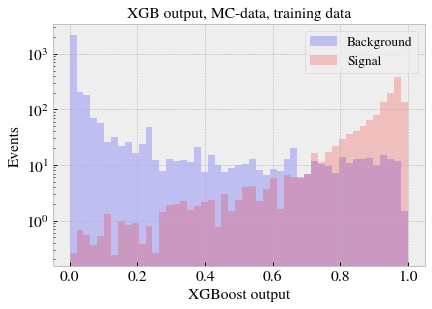

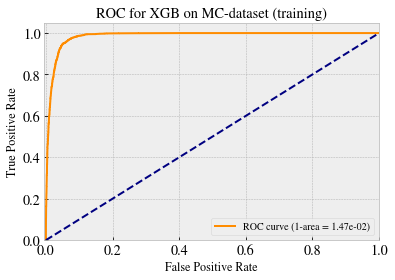

In [23]:
"""
TRAINING DATA
"""
y_pred = xgb.predict_proba( X_train ) 
y_b = y_pred[:,1][Y_train==0]
y_s = y_pred[:,1][Y_train==1]

name = "train.pdf"
title =  "XGB output, MC-data, training data"
plotHistoBS(y_b, y_s, wbkg, wsig, name, title,  nrBins = 50)

title = "ROC for XGB on MC-dataset (training)"

plotRoc(Y_train, y_pred, W_train, title)

Save Image? [y/n] n


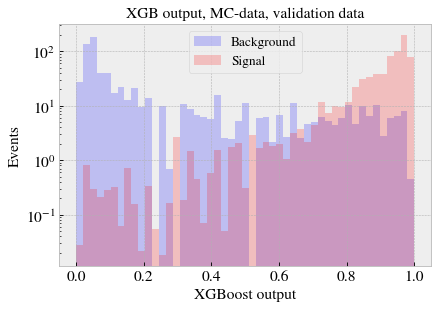

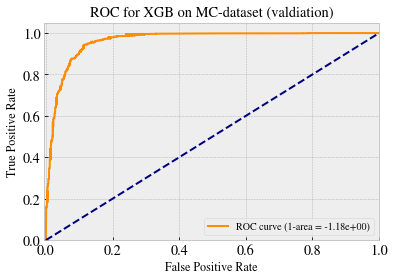

Best Threshold=0.651032, G-Mean=0.948


In [24]:
y_pred = xgb.predict_proba( X_val ) 
y_b = y_pred[:,1][Y_val==0]
y_s = y_pred[:,1][Y_val==1]

name = "figures/validation.pdf"
title =  "XGB output, MC-data, validation data"
plotHistoBS(y_b, y_s, wbkg_v, wsig_v, name, title, nrBins = 50)

title = "ROC for XGB on MC-dataset (valdiation)"
fpr, tpr, thresholds = plotRoc(Y_val, y_pred, W_val, title, return_score = True)
gmeans = np.sqrt(np.array(tpr) * (1-np.array(fpr)/np.max(np.array(fpr))))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_threshold, gmeans[ix]))

Save Image? [y/n] n


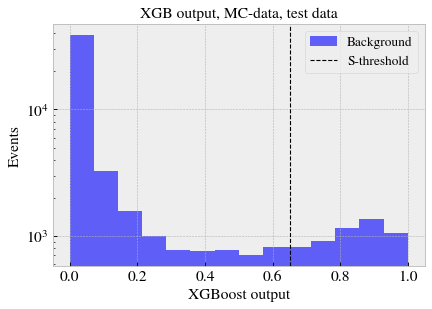

Nr of false positives 262485


In [25]:
"""
TEST DATA
"""
y_b = xgb.predict_proba( X_test )[:,1]

name = "figures/BackgroundMC.pdf"
title =  "XGB output, MC-data, test data"
plotHistoB(y_b, wbkg_t, name, title, best_threshold, nrBins = 15)
print(f"Nr of false positives {np.sum(y_b>best_threshold)}")

# Control Regions
In this section I will define the controll regions.